In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from env import user, host, password
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from acquire import get_zillow_data, train_val_test, acquire_zillow, prep_zillow, wrangle_zillow
import acquire
from pydataset import data
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor



In [2]:
# Select a dataset with a continuous target variable.
df = data('swiss')
df.head()

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6


In [5]:
# Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.
train, val, test = train_val_test(df)


In [6]:
train.head()


,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Le Locle,72.7,16.7,22,13,11.22,18.9
V. De Geneve,35.0,1.2,37,53,42.34,18.0
Broye,83.8,70.2,16,7,92.85,23.6
Nyone,56.6,50.9,22,12,15.14,16.7
Neuveville,76.9,43.5,17,15,5.16,20.6


In [8]:
X_train = train.drop(columns=['Fertility'])
y_train = train.Fertility

X_val = val.drop(columns=['Fertility'])
y_val = val.Fertility

X_test = test.drop(columns=['Fertility'])
y_test = test.Fertility

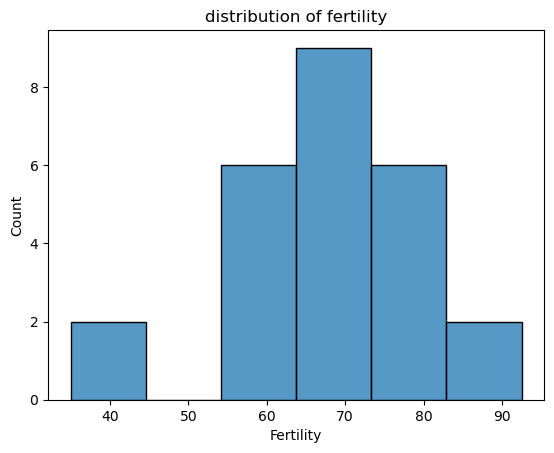

In [9]:
sns.histplot(y_train)
plt.title('distribution of fertility')
plt.show()

In [10]:
baseline = y_train.mean()
baseline

66.676

In [11]:
def metrics_reg(y, yhat):
    """
    send in y_true, y_pred & returns RMSE, R2
    """
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [12]:
baseline_array = np.repeat(baseline, len(train))
baseline_array[:5]

array([66.676, 66.676, 66.676, 66.676, 66.676])

In [13]:
rmse, r2 = metrics_reg(y_train, baseline_array)
rmse, r2

(12.288930954318198, 0.0)

In [15]:
metrics_df = pd.DataFrame(data=[{'model':'baseline','rmse':rmse,'r2':r2}])
metrics_df


,model,rmse,r2
0,baseline,12.288931,0.0


In [17]:
lr1 = LinearRegression()
rfe = RFE(lr1, n_features_to_select=1)
rfe.fit(X_train, y_train)
X_train_rfe = rfe.transform(X_train)
X_val_rfe = rfe.transform(X_val)
print('selected top feature:', rfe.get_feature_names_out())


selected top feature: ['Examination']


In [18]:
lr1.fit(X_train_rfe, y_train)
pred_lr1 = lr1.predict(X_train_rfe)
pred_val_lr1 = lr1.predict(X_val_rfe)

In [19]:
metrics_reg(y_train, pred_lr1)

(8.315773296831551, 0.5420932199082891)

In [21]:
rmse, r2 = metrics_reg(y_val, pred_val_lr1)
rmse, r2

(10.807031546027716, 0.2512057776745711)

In [22]:
metrics_df.loc[1] = ['ols_1', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,12.288931,0.000000
1,ols_1,10.807032,0.251206


In [23]:
lr2 = LinearRegression()
lr2.fit(X_train, y_train)
pred_lr2 = lr2.predict(X_train)
pred_val_lr2 = lr2.predict(X_val)

In [24]:
metrics_reg(y_train, pred_lr2)

(6.097552678228806, 0.7538029109479469)

In [25]:
rmse, r2 = metrics_reg(y_val, pred_val_lr2)
rmse, r2

(6.887634487354217, 0.6958485927206071)

In [26]:
metrics_df.loc[2] = ['ols', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,12.288931,0.000000
1,ols_1,10.807032,0.251206
2,ols,6.887634,0.695849


In [29]:
lars = LassoLars(alpha=1)
lars.fit(X_train, y_train)
pred_lars = lars.predict(X_train)
pred_val_lars = lars.predict(X_val)

In [30]:
metrics_reg(y_train, pred_lars)


(6.110988358343164, 0.752716747423101)

In [32]:
rmse, r2 = metrics_reg(y_val, pred_val_lars)
rmse, r2


(6.880032978426521, 0.6965195731049976)

In [33]:
metrics_df.loc[3] = ['lars', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,12.288931,0.000000
1,ols_1,10.807032,0.251206
2,ols,6.887634,0.695849
3,lars,6.880033,0.696520


In [35]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_val & X_test
X_validate_degree2 = pf.transform(X_val)
X_test_degree2 = pf.transform(X_test)

In [36]:
pr = LinearRegression()
pr.fit(X_train_degree2, y_train)
pred_pr = pr.predict(X_train_degree2)
pred_val_pr = pr.predict(X_validate_degree2)

In [37]:
metrics_reg(y_train, pred_pr)

(2.1536304978129217, 0.9692875701803919)

In [38]:
rmse, r2 = metrics_reg(y_val, pred_val_pr)
rmse, r2

(16.30114622093429, -0.7036717907950951)

In [39]:
metrics_df.loc[4] = ['poly_2', rmse, r2]
metrics_df

,model,rmse,r2
0,baseline,12.288931,0.000000
1,ols_1,10.807032,0.251206
2,ols,6.887634,0.695849
3,lars,6.880033,0.696520
4,poly_2,16.301146,-0.703672


In [42]:
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train, y_train)
pred_glm = glm.predict(X_train)
pred_val_glm = glm.predict(X_val)

In [43]:
metrics_reg(y_train, pred_glm)

(6.087939643512269, 0.7545785780687166)

In [45]:
rmse, r2 = metrics_reg(y_val, pred_val_glm)
rmse, r2

(6.547436268737765, 0.7251522373919728)

In [46]:
metrics_df.loc[5] = ['glm',rmse,r2]
metrics_df

,model,rmse,r2
0,baseline,12.288931,0.000000
1,ols_1,10.807032,0.251206
2,ols,6.887634,0.695849
3,lars,6.880033,0.696520
4,poly_2,16.301146,-0.703672
5,glm,6.547436,0.725152


In [48]:
pred_test_glm = glm.predict(X_test)

In [49]:
rmse, r2 = metrics_reg(y_test, pred_test_glm)
rmse, r2

(9.117401993469993, -0.24113895507269123)